# Exerise 2

The aims of this execise are to:

 - Make your first recommender by implementing a user-based CF (c.f. Lecture 4).
 - Make your first recommendations using Spotlight recommender toolkit on explicit data (Lecture 8).
 - Develop and evaluate baseline recommender systems (c.f. Lecture 3).
 - Start to think about explicit vs implicit learners.
 - Evaluate your results using Spotlight (Lecture 6 & 7).

This exercise builds on the lectures' material, namely Lectures 3, 4, 6, 7 and 8.

There are 10 tasks to increase your understanding of the content of the Recommender Sytems course.  Each of these tasks have corresponding questions in the quiz.

We're going to use the Spotlight library in Parts B & C - see https://github.com/maciejkula/spotlight - and its documentation at https://maciejkula.github.io/spotlight/. You can install this direct from Git, but using Craig's patched version as done below.

In [ ]:
!pip install git+https://github.com/cmacdonald/spotlight.git@master#egg=spotlight

  Cloning https://github.com/cmacdonald/spotlight.git (to revision master) to /tmp/pip-install-fnbxcg_t/spotlight_aa6350673b8441149d29a7978c4b893a
  Running command git clone -q https://github.com/cmacdonald/spotlight.git /tmp/pip-install-fnbxcg_t/spotlight_aa6350673b8441149d29a7978c4b893a


In [ ]:
# Import modules.
from collections import defaultdict
from itertools import count
from typing import List, Tuple
import time

from scipy.stats import rankdata
from spotlight.cross_validation import random_train_test_split
from spotlight.evaluation import mrr_score, rmse_score
from spotlight.factorization.explicit import ExplicitFactorizationModel
from spotlight.factorization.implicit import ImplicitFactorizationModel
from spotlight.interactions import Interactions
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn


SEED = 20

We'll be using Movielens again. Let's load it in to the dataframe.

In [ ]:
!curl -o ml-latest-small.zip http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
# !curl -o ml-latest-small.zip http://www.dcs.gla.ac.uk/~craigm/recsysHM/ml-latest-small.zip  # Backup location. Use it instead of the previous line if necessary.
!unzip -o ml-latest-small.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  2834k      0 --:--:-- --:--:-- --:--:-- 2826k
Archive:  ml-latest-small.zip
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [ ]:
ratings_df = pd.read_csv('ml-latest-small/ratings.csv')
movies_df = pd.read_csv('ml-latest-small/movies.csv')

# Treat userId as strings, and similarly as movies. This will prevent confusion later on.
ratings_df['userId'] = 'u' + ratings_df['userId'].astype(str)
ratings_df['movieId'] = 'm' + ratings_df['movieId'].astype(str)
movies_df['movieId'] = 'm' +  movies_df['movieId'].astype(str)

In [ ]:
ratings_df

,userId,movieId,rating,timestamp
0,u1,m1,4.0,964982703
1,u1,m3,4.0,964981247
2,u1,m6,4.0,964982224
3,u1,m47,5.0,964983815
4,u1,m50,5.0,964982931
...,...,...,...,...
100831,u610,m166534,4.0,1493848402
100832,u610,m168248,5.0,1493850091
100833,u610,m168250,5.0,1494273047
100834,u610,m168252,5.0,1493846352


In [ ]:
movies_df

,movieId,title,genres
0,m1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,m2,Jumanji (1995),Adventure|Children|Fantasy
2,m3,Grumpier Old Men (1995),Comedy|Romance
3,m4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,m5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,m193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,m193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,m193585,Flint (2017),Drama
9740,m193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


# Part A. User-based CF

You can generate a matrix of ratings with the `ratings_df` dataframe. In the matrix, the unrated items are filled with 0 (this means they have no impact upon the calculated cosine value).

In [ ]:
r_df_matrix = ratings_df.pivot_table(index = 'userId', columns = 'movieId', values = 'rating').fillna(0)
r_df_matrix

movieId,m1,m10,m100,m100044,m100068,m100083,m100106,m100159,m100163,m100194,m100226,m100277,m1003,m100302,m100304,m100306,m100326,m100383,m100390,m100397,m1004,m100487,m100498,m1005,m100507,m100527,m100553,m100556,m100579,m1006,m100611,m1007,m100714,m100737,m1008,m100810,m100843,m100882,m1009,m100906,...,m98836,m98908,m98961,m99,m990,m99005,m99007,m99030,m99087,m991,m99106,m99112,m99114,m99117,m99122,m99130,m99145,m99149,m99191,m993,m994,m99415,m99437,m99532,m99574,m996,m99636,m99638,m99721,m99728,m99750,m99764,m998,m99813,m99846,m99853,m999,m99910,m99917,m99992
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
u1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
u95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u96,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The left hand bold column is the [index of the dataframe](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html) - that is, an attribute of the dataframe that allows fast lookup of rows. In this case, userId has become our index column.

You can get all the index of users using the `.index`.

In [ ]:
r_df_matrix.index

Index(['u1', 'u10', 'u100', 'u101', 'u102', 'u103', 'u104', 'u105', 'u106',
       'u107',
       ...
       'u90', 'u91', 'u92', 'u93', 'u94', 'u95', 'u96', 'u97', 'u98', 'u99'],
      dtype='object', name='userId', length=610)

You can also use [`.loc`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html) to access rows, by their "index". For instance, we can get all ratings of a specific user with `userId` u1.

In [ ]:
r_df_matrix.loc['u1']

movieId
m1         4.0
m10        0.0
m100       0.0
m100044    0.0
m100068    0.0
          ... 
m99853     0.0
m999       0.0
m99910     0.0
m99917     0.0
m99992     0.0
Name: u1, Length: 9724, dtype: float64

User-based CF heavily relies upon cosine similarity. We are providing a cosine similarity implementation based on numpy operations. We also show how to use `df.loc` to get all the ratings of a given user from `r_df_matrix` as a Series - we then make this into a numpy array using the [`.values`](https://pandas.pydata.org/docs/reference/api/pandas.Series.values.html) property.

In [ ]:
def cos_sim(a, b) -> float:
  '''
  Compute cosine similarity between two users' rating matrices.

  Parameters
  ----------
  a : a user's rating matrix
  b : another user's rating matrix

  Returns
  -------
  cos_sim : the cosine similarity between two users' rating matrices
  '''

  return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


print('Cosine similarity between userId u1 and itself:', cos_sim(r_df_matrix.loc['u1'].values, r_df_matrix.loc['u1'].values))
print('Cosine similarity between userId u1 and userId u607:', cos_sim(r_df_matrix.loc['u1'].values, r_df_matrix.loc['u607'].values))

Cosine similarity between userId u1 and itself: 1.0
Cosine similarity between userId u1 and userId u607: 0.2693892401115333


## Task 1. Getting the most similar users

User-based CF is based on user-neighbourhoods. In this task, you will implement a function `get_most_similar_users()` that will identify the `userId` of the `k` most similar users to the specified `userId`, and their corresponding cosine similarities. 

In determining the most similar users, you should break ties based on their position in the array - for instance, if two users are tied as 2nd most similar user, the user who appears earlier should be 2nd, and the latter user third.

You should exclude the compared user itself when generating a list of the most similar users.

**Hints:** 
- The `cos_sim()` function should be used here. 
- Higher cosine similarity means more similar.
- Try SciPy's [`rankdata()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rankdata.html) function. Given an array, `rankdata()` tells you positions in sorted rank order. For instance:
```
>>> rankdata([5.9, 2.1, 4.3])
array([3., 1., 2.])
```
It also has support for addressing ties.
- The first return component of [np.nonzero()](https://numpy.org/doc/stable/reference/generated/numpy.nonzero.html) can be used to return the indices of the elements that are non-zero. E.g.
```
>>> np.array([True,False]).nonzero()[0]
array([0])
```

In [ ]:
def get_most_similar_users(user_id: str, k: int = 10) -> Tuple[np.ndarray, np.ndarray]:
  '''
  Get top k users and cosine similarities.

  Parameters
  ----------
  user_id : the userId of the compared user
  k : the number of top users and cosine similarities kept

  Returns
  -------
  top_k : a tuple containing two ndarrays of top k users and cosine similarities.
  '''

  top_k_users = r_df_matrix.index[r_df_matrix.index != user_id]  # An unsorted ndarray of userId of top k users excluding the compared user.
  top_k_cos = np.array([cos_sim(r_df_matrix.loc[user_id].values, r_df_matrix.loc[user].values) for user in top_k_users])  # An unsorted ndarray of top k cosine similarities with the same initial order as top_k_users.
  rank = np.argsort(-top_k_cos)  # Get the indices to sort an array as per cosine similarities from the highest to the lowest.
  return (top_k_users[rank][:k], top_k_cos[rank][:k])  # Rank users and cosine similarities, and return top k.

What is the `userId` and cosine similarity of the most similar user to `userId` u10? 

In [ ]:
print(get_most_similar_users('u10', 1))

(Index(['u159'], dtype='object', name='userId'), array([0.28826463]))


What is the cosine similarity of the 2nd most similar user to `userId` u500? 

In [ ]:
print(get_most_similar_users('u500', 2))

(Index(['u453', 'u45'], dtype='object', name='userId'), array([0.27983214, 0.26236875]))


## Task 2. Predicting ratings via user-based CF

Now you should implement your user-based CF, within a `predict_rating()` function. The aim of this function is to predict the rating of a given `userId` for a given `movieId`. Your implementation should make use of your `get_most_similar_users()` implementation above, using `k` = 10 nearest neighbours.

**Hint:**
- You may wish to revise user-based CF from Lecture 4.

In [ ]:
def predict_rating(user_id: str, movie_id: str) -> float:
  '''
  Predict a specific user's rating to a specific movie using weighted average by similarity.

  Parameters
  ----------
  user_id : the userId of the user
  movie_id : the movieId of the movie

  Returns
  -------
  predicted : the predicted rating (0 if no existing ratings for a specific movie from similar users)
  '''

  similar_users, cos = get_most_similar_users(user_id)  # Get top 10 users and cosine similarities.
  movie_ratings = np.array([r_df_matrix.loc[user][movie_id] for user in similar_users])  # Get specific movie ratings corresponding to the top 10 users.
  valid_users = np.nonzero(movie_ratings)[0]  # Filter out the users whose movie rating is 0 (unknown).
  return 0 if valid_users.size == 0 else np.sum([cos[valid_users] * movie_ratings[valid_users]]) / np.sum(cos[valid_users])  # Predict the rating using weighted average by similarity.

What is the predicted rating of `userId` u1 for `movieId` m1?

In [ ]:
print('Predicted rating:', predict_rating('u1', 'm1'))
print('Actual rating:', r_df_matrix.loc['u1']['m1'])

Predicted rating: 3.898822026597358
Actual rating: 4.0


You can complete answering the quiz questions for Task 2.

## Task 3. Predicting ratings via user-based CF with mean-centring normalisation

Users usually rate differently. Some rate high, while others low. Some use more of the scale than others. However, the user-based CF we implemented above ignores these differences. To this end, we can apply normalisation to compensate. In this task, you will implement user-based CF with mean-centring normalisation - the functions `mean_rating()` and `predict_rating_MC()`.

**Hints:**
- See lecture 4 about user-based CF with Mean-center normalisation. 
- Check if the predicted rating for a given user makes sense (i.e. what did the user rate before)?

In [ ]:
def mean_rating(user_id: str) -> float:
  '''
  Compute the mean of a user's ratings.

  Parameters
  ----------
  user_id : the userId of the user

  Returns
  -------
  rating_mean : the mean of a user's ratings
  '''

  return ratings_df[ratings_df['userId'] == user_id]['rating'].mean()  # Consider the mean of a user's known ratings.

def predict_rating_MC(user_id: str, movie_id: str) -> float:
  '''
  Predict a specific user's rating to a specific movie using weighted average by similarity and mean-centring.

  Parameters
  ----------
  user_id : the userId of the user
  movie_id : the movieId of the movie

  Returns
  -------
  predicted : the predicted rating (0 if no existing ratings for a specific movie from similar users)
  '''

  similar_users, cos = get_most_similar_users(user_id)  # Get top 10 users and cosine similarities.
  movie_ratings = np.array([r_df_matrix.loc[user][movie_id] for user in similar_users])  # Get specific movie ratings corresponding to the top 10 users.
  valid_users = np.nonzero(movie_ratings)[0]  # Filter out the users whose movie rating is 0 (unknown).

  if valid_users.size:
    mean_ratings = np.array([mean_rating(user) for user in similar_users[valid_users]])  # Get the mean ratings for valid users.
    return mean_rating(user_id) + np.sum([cos[valid_users] * (movie_ratings[valid_users] - mean_ratings)]) / np.sum(cos[valid_users])  # Predict the rating using weighted average by similarity and mean-centring.
  
  return 0  # Return 0 if no valid users.

What is the mean rating of user u5?

In [ ]:
print('Mean rating:', mean_rating('u5'))

Mean rating: 3.6363636363636362


What is the predicted rating of `userId` u1 for `movieId` m1?

In [ ]:
print('Predicted rating:', predict_rating_MC('u1', 'm1'))
print('Actual rating:', r_df_matrix.loc['u1']['m1'])

Predicted rating: 4.769198526598024
Actual rating: 4.0


Now answer the questions for Task 3 in the quiz.

# Part B - Explicit Matrix Factorisation using Spotlight

In this part, we will investigate explicit matrix factorisation.

Now we can get onto some real recommendation work. Spotlight has a handy [Interactions](https://maciejkula.github.io/spotlight/interactions.html) object, which encapsulates the basics of a recommendation dataset.

In fact, there are handy loaders for a few standard datasets including MovieLens, but let's make our own, so that we can match back to the dataframe.

Interactions need numbers as user IDs and item IDs. Unfortunately, our MovieLens uses numbers, but these aren't consecutive (i.e. we have missing `movieId` values). They are also strings (i.e. `movieId` starts with "m" and `userId` starts with "u").

Hence, for both movies and users, we will use [defaultdict](https://docs.python.org/3/library/collections.html#collections.defaultdict) to convert the MovieLens strings down to consecutive integers for use in Spotlight, in the `uid_map` and `iid_map` objects. We'll keep the reverse mapping around too, in case we want to lookup the actual `movieId` given the `uid` recorded by Spotlight (etc).

**NB**: This is a really important concept to understand. Put simply, WE -- as humans -- deal with external representations (`userId`, `movieId`, in this dataset prefixed with "u" and "m" respectively). On the other hand, Spotlight can only deal with integers starting from 0 for both items and users (we call these `iid` and `uid`). 

In [ ]:
uid_map = defaultdict(count().__next__)  # Create userId -> uid mapping dictionary. The next assigned value is the current size.
iid_map = defaultdict(count().__next__)  # Ditto for movieId -> iid.

# uids is an array of integers corresponding to the userId for every row in ratings_df.
# uid_map does the assignment of new uid values, or reusing the uid value assigned for each userId.
# Ditto for iids and iid_map
uids = np.array([uid_map[uid] for uid in ratings_df['userId'].values], dtype = np.int32)
iids = np.array([iid_map[iid] for iid in ratings_df['movieId'].values], dtype = np.int32)

# Freeze uid_map and iid_map, so no more mappings are created.
uid_map.default_factory = None
iid_map.default_factory = None

# Reverse them, so we can go from iid (int) to itemId (str)
uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}

# Get ratings and timestamps values.
ratings = ratings_df['rating'].values.astype(np.float32)
timestamps = ratings_df['timestamp'].values.astype(np.int32)

print('%d users %d items' % (len(uid_map), len(iid_map)))
print('userId u556 got uid', uid_map['u556'])
print('movieId m54001 got iid', iid_map['m54001'])

610 users 9724 items
userId u556 got uid 555
movieId m54001 got iid 2518


Furthemore, we will use user u556 as one of our illustrative users. You will remember from Exercise 1 that the user rated a number of fantasy movies highly.



## On towards MF

Now let's build a Spotlight [Interactions](https://maciejkula.github.io/spotlight/interactions.html) object. This contains everything that Spotlight needs to train a model. We can split it up randomly into train and test subsets.

**NB:** We use a SEED (20) to make our results reproducible.

In [ ]:
dataset = Interactions(
    user_ids = uids,
    item_ids = iids,
    ratings = ratings,
    timestamps = timestamps
)

train, test = random_train_test_split(dataset, random_state = np.random.RandomState(SEED))

Let's see how big the two datasets are. What is the train/test split percentage size? (The default fraction of interactions to place in the test set is 0.2.)

In [ ]:
print(train)
print(test)

<Interactions dataset (610 users x 9724 items x 80668 interactions)>
<Interactions dataset (610 users x 9724 items x 20168 interactions)>


Here, you can see that following the collaborative filtering task model (see Lecture 6), all users and all items are present in both training and test sets.

Now, you can think of the Interaction objects are being the partitions of the rating matrix. But we don't store it as a single big matrix. Instead, we record three one-dimensional arrays:

- one for the IDs of the users
- one for the IDs of the items
- one for the actual rating values.

Each of these arrays is the size of the number of ratings (80668 for the training set).

In essence, Interactions is a sparse matrix - for each rating, we record its x and y position, as well as the rating itself.

In [ ]:
print(train.item_ids.shape)
print(train.user_ids.shape)
print(train.ratings.shape)

(80668,)
(80668,)
(80668,)


For instance, let's look at the first rating.

In [ ]:
print("uid %d gave iid %d a rating of %d" % (train.user_ids[0], train.item_ids[0], train.ratings[0]))

uid 56 gave iid 1491 a rating of 2


Let's take our favourite fantasy adventure fan from Exercise 1, `userId` u556. We can give a look at their training ratings.

In [ ]:
user_id = 'u556'
uid = uid_map.get(user_id)  # Map userId to the internal uid value.

# See which movies and ratings are for this user.
print('iid:', train.item_ids[train.user_ids == uid])
print('Ratings:', train.ratings[train.user_ids == uid])

iid: [6082 6087  457 1925 7951 1132  764 5989  753 1342 1893 3076 3258 1182
 1938 1894 4796  926  770 8659 2059  917 1077  912  779  322 1307 3087
 2518  774]
Ratings: [4.  3.5 5.  5.  4.  4.  4.  4.  4.5 4.  4.  4.5 4.  4.  4.5 3.5 4.  4.
 4.  4.  4.  3.5 5.  2.5 4.  5.  4.  4.  4.  4. ]


We can now learn a model. Let's start with a matrix factorisation for explicit data. We train the Spotlight's [`ExplicitFactorizationModel`](https://maciejkula.github.io/spotlight/factorization/explicit.html#) using the `fit` method. This is just like the `fit` in Sklearn - we're fitting a default model to the specified training data.

This might take up to a minute. 

**NB:** Spotlight can support using GPUs which we could use to slightly speed up training time, but that will make our life more difficult later on, so let's ignore this for now.

In [ ]:
emodel = ExplicitFactorizationModel(random_state = np.random.RandomState(SEED))
current = time.time()
emodel.fit(train, verbose = True)
end = time.time()
print('Training took %d seconds' % (end - current))

Epoch 0: loss 4.3081090674747395
Epoch 1: loss 0.8099101063194154
Epoch 2: loss 0.5096786571077153
Epoch 3: loss 0.3636633798102789
Epoch 4: loss 0.2919712789073775
Epoch 5: loss 0.25697739233699024
Epoch 6: loss 0.23643478482395788
Epoch 7: loss 0.22271784451566165
Epoch 8: loss 0.2139979781983774
Epoch 9: loss 0.20728877597028697
Training took 14 seconds


How well did we do? Well, let's give a look at the recommentations, for our specific user, `userId` u556.

In [ ]:
test_item_id = test.item_ids[test.user_ids == uid][0]  # Pick one rating that the user made.
movie_id = iid_rev_map.get(test_item_id)  # Map the internal iid value to the movieId.
print('One test item ID for userId %s (uid %d) is movieId %s (iid %d)' % (user_id, uid, iid_rev_map.get(test_item_id), test_item_id))

predicted = emodel.predict(np.array([uid]), item_ids = np.array([0, test_item_id]))[1]  # Here 0 is a dummy item, which Spotlight needs for some reason. We discard its prediction using [1].
actual = ratings_df[(ratings_df['userId'] == user_id) & (ratings_df['movieId'] == movie_id)]['rating'].values[0]  # The actual score of the user for that movie.
print('Predicted rating for "%s" was %f, actual rating %.1f, error was %f' % (
    movies_df[movies_df['movieId'] == movie_id]['title'].values[0],
    predicted,
    actual,
    abs(predicted - actual)
))

One test item ID for userId u556 (uid 555) is movieId m74530 (iid 8141)
Predicted rating for "Percy Jackson & the Olympians: The Lightning Thief (2010)" was 2.574092, actual rating 3.5, error was 0.925908


So this is interesting - while we saw above that the users liked fantasy movies, we predicted a rating of $\sim 2.5$, but the user gave this particular movie a 3.5.

We can also ask for **all** of the recommendations for a given user u556.

In [ ]:
allpreds = emodel.predict(np.array([uid]))
print(allpreds)
print(allpreds.size)
print(allpreds[test_item_id])  # Recover the original rating for our test item.
print(allpreds[test_item_id] - actual < 0.1)  # Check we got the correct prediction.

[3.9689248  4.3499784  4.5101566  ... 0.87423515 2.7873065  0.9850692 ]
9724
2.5740924
True


## Latent Factors aka Embeddings

Let's see how these recommendations are made. Remember from Lecture 8 that the prediction is made based on the dot product of the user's and item's latent factors (also know as "embeddings").

We can access these embeddings directly from the `emodel` object. Each embedding has 32 dimensions, which is what Spotlight sets when using the default Explicit Factorisation Model.

In [ ]:
# A PyTorch tensor can be thought of having similar semantics as a numpy array.
print('Dimension 0 -')
print('User embeddings:', emodel._net.user_embeddings.weight[0])
print('Movie embeddings:', emodel._net.item_embeddings.weight[0])

Dimension 0 -
User embeddings: tensor([ 0.9949, -0.0203,  0.5183, -0.5834,  0.3204,  0.1194,  0.1783,  0.2095,
         0.5180, -0.0313, -0.0679,  0.8740,  0.1025,  0.4426,  0.0245,  0.3884,
         0.1170,  0.0406, -0.0458,  0.2030, -0.2486, -0.8601,  0.5501,  0.3770,
        -0.0193, -0.2196,  0.2495, -0.1036, -0.4725, -0.5731, -0.3454,  0.4075],
       grad_fn=<SelectBackward>)
Movie embeddings: tensor([ 0.1223, -0.3951, -0.3488,  0.0474,  0.7867, -0.0242,  0.2448,  0.7672,
        -0.1924, -0.0686, -0.1228,  0.6061, -0.1798, -0.3621,  0.7326,  0.2025,
        -0.1660, -0.3077, -0.3590, -0.3852,  0.2369, -0.6257,  0.7370,  0.8468,
         0.0755, -0.4360, -0.1154, -0.2451, -0.0357, -0.0060,  0.1001,  0.2164],
       grad_fn=<SelectBackward>)


We can check how Spotlight makes its prediction. The key line is https://github.com/maciejkula/spotlight/blob/master/spotlight/factorization/representations.py#L89.

This takes the (dot-)product of the user's "embedding" (latent factor) and the item's embedding. On top of these are added "user_biases" and "item_biases". What do you think these last two components are for? You could refer to [this link](https://stats.stackexchange.com/questions/113390/the-role-of-the-bias-terms-in-matrix-factorization-formulas) for some inspiration.

Let's reproduce this for our favourite user u556.

In [ ]:
dotprod = (emodel._net.user_embeddings.weight[uid] * emodel._net.item_embeddings.weight[test_item_id]).sum(0)
user_bias = emodel._net.user_biases(torch.tensor([uid]))
item_bias = emodel._net.item_biases(torch.tensor([test_item_id], dtype = torch.long))

print(movies_df[movies_df['movieId'] == movie_id]['title'].values[0])
dotprod + user_bias + item_bias

Percy Jackson & the Olympians: The Lightning Thief (2010)


tensor([[2.5741]], grad_fn=<AddBackward0>)

## Task 4. Examining Latent Factors

Let's give a look at item-item similarities. Write a function `most_similar()` that identifies the most similar `movieId` to the specified target, based on the cosine similarity of their item embedding vectors. 

What's the closest movie to "Harry Potter and the Deathly Hallows: Part 1 (2010)" (`movieId` m81834) in the MovieLens dataset?

**Hint:**
- Since we're working with PyTorch tenors, you should use [`nn.functional.cosine_similarity(x, y, dim = 0)`](https://pytorch.org/docs/stable/nn.functional.html#cosine-similarity) to calculate the cosine similarity between two vectors x & y, as demonstrated below between two orthogonal vectors:

In [ ]:
nn.functional.cosine_similarity(torch.tensor([1., 0]), torch.tensor([0, 1.],), dim = 0)

tensor(0.)

In [ ]:
def most_similar(target_iid: int, model: ExplicitFactorizationModel) -> None:
  '''
  Locate the most similar movie based on the cosine similarity of the item embedding vectors.

  Parameters
  ----------
  target_iid : the iid of the target movie
  model : the explicit factorisation model
  '''

  # Initialise the iid with the highest cosine similarity.
  highest = 0
  highest_cos = 0

  # Find the real highest cosine similarity.
  for iid, item_embedding in enumerate(model._net.item_embeddings.weight):
    if iid != target_iid:
      cos = nn.functional.cosine_similarity(model._net.item_embeddings.weight[target_iid], item_embedding, dim = 0).item()

      if cos > highest_cos:
        highest = iid
        highest_cos = cos

  target_movie_id = iid_rev_map.get(target_iid)
  similar_movie_id = iid_rev_map.get(highest)
  print('Target movie "%s" (movieId %s, iid %d)' % (
      movies_df[movies_df['movieId'] == target_movie_id]['title'].values[0],
      target_movie_id,
      target_iid))
  print('Most similar movie "%s" (movieId %s, iid %d) with cosine similarity of %f' % (
      movies_df[movies_df['movieId'] == similar_movie_id]['title'].values[0],
      similar_movie_id,
      highest,
      highest_cos))

What is the predicted rating for userId u1 for movieId m1.

In [ ]:
most_similar(iid_map['m81834'], emodel)

Target movie "Harry Potter and the Deathly Hallows: Part 1 (2010)" (movieId m81834, iid 1933)
Most similar movie "Harry Potter and the Half-Blood Prince (2009)" (movieId m69844, iid 917) with cosine similarity of 0.793590


What is the `movieId` and cosine similarity of the most similar movie to m88125?

In [ ]:
most_similar(iid_map['m88125'], emodel)

Target movie "Harry Potter and the Deathly Hallows: Part 2 (2011)" (movieId m88125, iid 1938)
Most similar movie "Harry Potter and the Half-Blood Prince (2009)" (movieId m69844, iid 917) with cosine similarity of 0.765978


## Evaluating performance

Finally, let's see how good we are at our rating predictions. Handily, Spotlight implements a few common evaluation measures for us to inspect.

In [ ]:
train_rmse = rmse_score(emodel, train)
test_rmse = rmse_score(emodel, test)
print('Train RMSE {:.3f}, test RMSE {:.3f}'.format(train_rmse, test_rmse))

Train RMSE 0.421, test RMSE 1.078


## Task 5. Tuning

It's appropriate to tune the latent factors. Normally we would use a held-out *validation* for setting the parameters, but as an exercise it is useful to examine performance on the training and test data.

The task here is to:

- Train and evaluate new instances of `ExplicitFactorizationModel` using different numbers of latent factors, while leaving the other parameters unchanged. Vary the factors in `[8,16,32,64]`.
- Record the training time for different numbers of latent factors.
- Evaluate and record the RMSE values of the resulting models on both the training and test sets.
- Use matplotlib to create a graph showing how training and test RMSE change as the number of latent factors is varied. Use [plt.savefig()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html) to save a PNG of your graph.

In [ ]:
embedding_dims = [8, 16, 32, 64]  # Define a list of the number of latent factors to vary.
training_time_results = []
train_rmses = []
test_rmses = []

# Apply EFM using different numbers of latent factors.
for embedding_dim in embedding_dims:
  emodel = ExplicitFactorizationModel(embedding_dim = embedding_dim, random_state = np.random.RandomState(SEED))  # Build an EFM.
  current = time.time()
  emodel.fit(train)  # Fit the model.
  end = time.time()
  training_time = end - current  # Record the training time.
  train_rmse = rmse_score(emodel, train)  # Compute RMSE of the training set.
  test_rmse = rmse_score(emodel, test)  # Compute RMSE of the test set.
  training_time_results.append(training_time)
  train_rmses.append(train_rmse)
  test_rmses.append(test_rmse)
  print('%d latent factors, training time %d sec, train RMSE %.3f, test RMSE %.3f' % (embedding_dim, training_time, train_rmse, test_rmse))

8 latent factors, training time 8 sec, train RMSE 0.577, test RMSE 1.011
16 latent factors, training time 10 sec, train RMSE 0.483, test RMSE 1.048
32 latent factors, training time 14 sec, train RMSE 0.421, test RMSE 1.078
64 latent factors, training time 24 sec, train RMSE 0.468, test RMSE 1.038


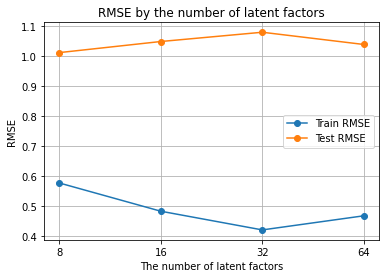

In [ ]:
plt.plot(train_rmses, label = 'Train RMSE', marker = 'o')
plt.plot(test_rmses, label = 'Test RMSE', marker = 'o')
plt.title('RMSE by the number of latent factors')
plt.xlabel('The number of latent factors')
plt.xticks(labels = embedding_dims, ticks = np.arange(4))
plt.ylabel('RMSE')
plt.grid()
plt.legend()
# plt.savefig('task5.png')
plt.show()

## Evaluating Other Models

When evaluating models, it's important to compare to some reasonable baselines. 

Fortunately, Spotlight's `rmse_score()` method can be used to evaluate any Python object that adheres to the specification of the `predict()` function. For instance, we can make a baseline "static" scoring model, which returns the same scores for each user. This set of scores is passed as numpy array in the constructor.

In [ ]:
class StaticModel:
  '''
  The class for a baseline static scoring model.
  '''

  def __init__(self, static_scores: np.ndarray) -> None:
    '''
    The constructor of the class for a baseline static scoring model.

    Parameters
    ----------
    static_scores : the static scores
    '''

    self.n_items = len(static_scores)
    self.static_scores = static_scores

  def predict(self, uids, iids = None) -> list:
    '''
    Predict the static scores.

    Parameters
    ----------
    uids : the user(s) we are requesting recommendations for
    iids : the specified item

    Returns
    -------
    scores : the static scores, one for each item, duplicated for each user requested
    '''

    uids = [uids] if isinstance(uids, int) else uids  # Respond to one or more uids.
    iids = np.arange(self.n_items) if iids is None else iids  # If iid is specificed, we filter predicts for the userId.
    return [self.static_scores[iids] for _ in uids]

For instance, we can make a static baseline that just returns 0 for every item, regardless of the user.

In [ ]:
dummy_model = StaticModel(np.zeros(len(iid_map)))
print('Asking for 2 users, 1 item:', dummy_model.predict([0, 1], 0))
print('Asking for 1 user, 1 item:', dummy_model.predict(0, 0))
print('Asking for 1 user, 2 items:', dummy_model.predict(0, [0, 1]))
print('RMSE of our dummy model:', rmse_score(dummy_model, test))

Asking for 2 users, 1 item: [0.0, 0.0]
Asking for 1 user, 1 item: [0.0]
Asking for 1 user, 2 items: [array([0., 0.])]
RMSE of our dummy model: 3.64275783561697


## Task 6. Popularity-based Recommenders

This task asks you to implement other baseline recommenders.

**Using `ratings_df`**, create 3 new instances of StaticModel as baselines:

(a). the number of ratings - you must linearly normalise this to be in the range 0-5.

(b). the number of top ratings (i.e., the rating value is 5) received by an item - you must linearly normalise this to be in the range 0-5.

(c). the average rating value for each item (no need to normalise - scores are already 0-5)

Evaluate your baseline models in terms of RMSE, as well as providing their scores for particular iids, as requested in the quiz.

**Hints:**
- You may find iterating over a dataframe using `iterrows()` useful - e.g. see https://stackoverflow.com/a/16476974.
- You may refer to [this link](https://stats.stackexchange.com/questions/25894/changing-the-scale-of-a-variable-to-0-100) for some inspiration for rescaling.
- Order is VERY IMPORTANT. Think carefully about the assumed order that `predict()` returns item scores for.

In [ ]:
def rescale(n_ratings: np.ndarray) -> np.ndarray:
  '''
  Rescale the number of ratings to the range 0 - 5.

  Parameters
  ----------
  n_ratings : the number of ratings for each item

  Returns
  -------
  n_ratings_rescaled : the rescaled number of ratings for each item.
  '''

  n_ratings_min = np.min(n_ratings)  # Store MIN_o (o: old).
  return 5 / (np.max(n_ratings) - n_ratings_min) * (n_ratings - n_ratings_min)  # (MAX_n - MIN_n) / (MAX_o - MIN_0) * (v - MIN_o) + MIN_n (n: new, v: value).


# The assumed item order in StaticModel's predict() is the same as iid_map (i.e., the order of unique movies in ratings_df).
# Use "sort = False" to preserve the order of unique movies in ratings_df.
n_ratings = rescale(ratings_df.groupby(['movieId'], sort = False)['rating'].count().values)  # Get the number of ratings for each item, rescaled to the range 0 - 5.
n_top_ratings = rescale(ratings_df.groupby(['movieId'], sort = False)['rating'].apply(lambda rating : (rating == 5).sum()).values)  # Get the number of top ratings for each item, rescaled to the range 0 - 5.
mean_ratings = ratings_df.groupby(['movieId'], sort = False)['rating'].mean().values  # Get the mean rating value for each item.

# Build the 3 baseline models.
model_a = StaticModel(n_ratings)
model_b = StaticModel(n_top_ratings)
model_c = StaticModel(mean_ratings)

# Evaluate RMSE.
print('RMSE of Model A:', rmse_score(model_a, test))
print('RMSE of Model B:', rmse_score(model_b, test))
print('RMSE of Model C:', rmse_score(model_c, test))

RMSE of Model A: 2.899816663013065
RMSE of Model B: 3.3080173160912762
RMSE of Model C: 0.8810745544813008


What is the predicted rating of each model for `iid` 0? 

In [ ]:
print('Prediction of Model A:', model_a.predict(0, 0))
print('Prediction of Model B:', model_b.predict(0, 0))
print('Prediction of Model C:', model_c.predict(0, 0))

Prediction of Model A: [3.2621951219512195]
Prediction of Model B: [1.5359477124183007]
Prediction of Model C: [3.9209302325581397]


# Part C - Implicit Recommendation

This part of the lab uses a music dataset from [Last.fm](https://www.last.fm/) -- a Spotify-like music streaming service -- that was obtained by a researcher at Pompeu Fabra University (Barcelona, Spain). The relevant citation is:

```
  @book{Celma:Springer2010,
      	author = {Celma, O.},
      	title = {{Music Recommendation and Discovery in the Long Tail}},
       	publisher = {Springer},
       	year = {2010}
      }
 ```

You can have more information about the dataset at [this link](http://ocelma.net/MusicRecommendationDataset/lastfm-1K.html).

## Dataset preparation

This dataset is 600MB copmressed, and 2.4GB uncompressed. It takes 30 seconds to download on Colab.

In [ ]:
!rm -rf lastfm-dataset-1K.tar.gz
!curl -o lastfm-dataset-1K.tar.gz http://www.dcs.gla.ac.uk/~craigm/recsysH/lastfm-dataset-1K.tar.gz
# !curl -o lastfm-dataset-1K.tar.gz http://macavaney.us/misc/lastfm-dataset-1K.tar.gz  # Backup location. Use it instead of the previous line if necessary.
!tar -zxvf lastfm-dataset-1K.tar.gz
!ls -lh lastfm-dataset-1K/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  641M  100  641M    0     0  25.4M      0  0:00:25  0:00:25 --:--:-- 25.2M
lastfm-dataset-1K/
lastfm-dataset-1K/userid-profile.tsv
lastfm-dataset-1K/README.txt
lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv
total 2.4G
-rw-r--r-- 1 1002 1002 2.2K Mar 23  2010 README.txt
-rw-r--r-- 1 1002 1002  37K Dec 30  2009 userid-profile.tsv
-rw-r--r-- 1 1002 1002 2.4G Mar  4  2010 userid-timestamp-artid-artname-traid-traname.tsv


In [ ]:
listens_df = pd.read_csv('lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv', header = None, names = ['user', 'timestamp', 'artistid', 'artist', 'trackid', 'trackname'], sep = '\t')

# Some tracks don't seem to have artists or track names, so let's drop them for simplicity.
listens_df = listens_df[listens_df.artist.notnull()]
listens_df = listens_df[listens_df.trackname.notnull()]

listens_df = listens_df.sample(n = 200000, random_state = np.random.RandomState(SEED))  # The dataframe is VERY big (19M interactions), so let's just work with a small sample of it (this will mean that effectiveness will be lower, but learning will be MUCH faster).

Let's look at the dataset. Note that the we don't have any explicit ratings by the users. We just know what they interacted with (and when).

In [ ]:
listens_df

,user,timestamp,artistid,artist,trackid,trackname
11087179,user_000593,2007-05-14T18:49:03Z,ad996aef-cc1c-42ac-af5c-619c370f4b8a,"Emerson, Lake & Palmer",NaN,Three Fates (Clotho/Lachesis/Atropos)
1911790,user_000093,2008-08-18T22:04:59Z,8c538f11-c141-4588-8ecb-931083524186,Bloc Party,315a301e-e764-4adf-91c6-e90a22320106,Positive Tension
11099786,user_000594,2008-04-06T10:57:45Z,65f4f0c5-ef9e-490c-aee3-909e7ae6b2ab,Metallica,683c89fe-2be8-4ed2-8e58-68b2343cb8d5,Through The Never
12076983,user_000651,2008-05-10T07:14:45Z,3ca09fae-fdee-4771-bab9-244708515a98,Omarion,NaN,Ice Box [Orangefuzzz Weather Advisory Radio Mix]
2680461,user_000137,2009-03-11T23:17:22Z,af84ee9f-534a-4f7f-844b-188ba1c47e87,Los Rodríguez,76b83f07-3763-4c17-8d24-28040d85354a,Dulce Condena
...,...,...,...,...,...,...
12309850,user_000667,2007-06-27T23:23:24Z,69b39eab-6577-46a4-a9f5-817839092033,Kasabian,47ec6792-3c84-48fc-b3a4-f047de6c6405,By My Side
16476660,user_000848,2008-05-29T13:09:48Z,9a04dc8c-82f1-457a-a25a-3ff19e1b471e,St. Germain,e4910740-2347-4729-83b1-73360628751a,Rose Rouge
510193,user_000022,2007-11-03T22:28:52Z,0eb6e8c3-1fc6-4624-83fc-a11c0e292a32,Rosemary,NaN,I'Ll Match Your Hate (With All Of My Love)
8740990,user_000461,2008-10-12T08:28:12Z,84800c46-2211-43e0-8a87-bdcbecf91932,Aphrodite,17aaf7a5-fee9-48a4-ac3e-a5c35d4a73fb,Summer Breeze


## An implicit recommendation approach

Let's move away from explicit recommendation to implicit. We will continue using the [Spotlight](https://github.com/maciejkula/spotlight/) toolkit for our recommender. We can construct [Interaction](https://maciejkula.github.io/spotlight/interactions.html) objects for Spotlight in the same way as before. The only difference is that this time we do not record the user's ratings.

In [ ]:
# We can't trust the musicbrainz IDs to exist, so let's build item IDs based on artist & trackname attributes.
LFMiid_map = defaultdict(count().__next__)
LFMiids = np.array([LFMiid_map[artist + '/' + trackname] for artist, trackname in listens_df[['artist', 'trackname']].values], dtype = np.int32)

# Ditto for user IDs.
LFMuid_map = defaultdict(count().__next__)
LFMuids = np.array([LFMuid_map[uid] for uid in listens_df['user'].values], dtype = np.int32)

# Freeze uid_map and iid_map, so no more mappings are created.
LFMuid_map.default_factory = None
LFMiid_map.default_factory = None

LFMuid_rev_map = {v: k for k, v in LFMuid_map.items()}
LFMiid_rev_map = {v: k for k, v in LFMiid_map.items()}

# We will set Interactions' num_users and num_items here - it's a good practice.
imp_dataset = Interactions(user_ids = LFMuids, item_ids = LFMiids, num_users = len(LFMuid_map), num_items = len(LFMiid_map))
print(imp_dataset)

<Interactions dataset (973 users x 125076 items x 200000 interactions)>


In [ ]:
itrain, itest = random_train_test_split(imp_dataset, random_state = np.random.RandomState(SEED))
print(itrain)
print(itest)

<Interactions dataset (973 users x 125076 items x 160000 interactions)>
<Interactions dataset (973 users x 125076 items x 40000 interactions)>


Let's run Spotlight's [`ImplicitFactorizationModel`](https://maciejkula.github.io/spotlight/factorization/implicit.html) on this dataset. Here, we use a *pointwise* loss, which just tries to predict whether the user will like the item or not. It does not use the BPR loss function (more on that later).

**Warning**: This dataset is difficult for the learner - this *will* take a few minutes to learn. Use the time to read-on.

In [ ]:
imodel = ImplicitFactorizationModel(n_iter = 5, random_state = np.random.RandomState(SEED))
current = time.time()
imodel.fit(itrain, verbose = True)
end = time.time()
print("Training took %d seconds" % (end - current))

Epoch 0: loss 0.9663112537384033
Epoch 1: loss 0.4953250964164734
Epoch 2: loss 0.19036926743984223
Epoch 3: loss 0.11518938970565797
Epoch 4: loss 0.08347186335921288
Training took 169 seconds


Again, we can look at the predictions. We make a prediction (a score) for ALL items for user `uid` 0. Note that the scores vary in magnitude - indeed, we're not predicting a rating, we just need to have scores in order to rank the items in descending order.

In [ ]:
print(imodel.predict(0))
print(len(imodel.predict(0)))

[ -4.757586   5.261482  -9.297717 ...  -9.027796 -11.657988 -13.502052]
125076


Now that we have the scores of all items for a given user, we need to identify the top-scored ones, i.e. those that we would present to the user.

## Task 7. Track Analysis

Write a function `tracks_for_user()` to identify the artist name & track of the top `k` (e.g. 4) items based on their score for a given user index (i.e. 0...964).

**Hints:**
- You might found [`np.argwhere()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argwhere.html) to be useful. It results only the positions of an array that are True. For instance:
```
>>> np.argwhere([True, False])
array([[0]])
```
Alternatively, you can sort and then slice.

In [ ]:
def tracks_for_user(uid: int = 4, k: int = 10) -> pd.DataFrame:
  '''
  Identify the artist name and track of the top k items based on their score for a specific user.

  Parameters
  ----------
  uid : the uid of the user
  k : the number of top items kept

  Returns
  -------
  top_tracks_df : a dataframe containing the top k items and scores
  '''

  track_scores = imodel.predict(uid)  # Predict scores for tracks.

  # Storing the indices that would sort the scores in descending order equals sorting iids since the indices equal iids.
  # Keep the top k tracks and corresponding scores.
  top_LFMiids = np.argsort(-track_scores)[:k]
  top_tracks = [LFMiid_rev_map[LFMiid] for LFMiid in top_LFMiids]
  top_scores = track_scores[top_LFMiids][:k]

  return pd.DataFrame({
      'Rank': np.arange(1, 11),
      'Artist/Trackname': top_tracks,
      'Score': top_scores
  }).set_index('Rank')

What are the top scored 10 tracks recommended for user `uid` 4?

In [ ]:
tracks_for_user()

,Artist/Trackname,Score
Rank,,
1,Evanescence/Sweet Sacrifice,13.124245
2,Mgmt/Kids,12.674792
3,The Killers/Bones,12.663386
4,Nelly Furtado/Say It Right,12.464123
5,Kings Of Leon/Use Somebody,12.436810
6,Amy Winehouse/Back To Black,12.173255
7,Red Hot Chili Peppers/The Zephyr Song,11.530579
8,Radiohead/Fake Plastic Trees,10.859724
9,Incubus/Drive,10.710403


## Task 8. Artist Analysis

Look at the artists actually listened to by `uid` 4, and compare/contrast with the predictions of the recommender. It's useful to examine how many times each artist was listened to.

**Hints:**
- Use a `groupby()` on a suitable subset of the `listens_df` dataframe. 
- Sort by descending frequency of listen.

In [ ]:
listens_df[listens_df['user'] == LFMuid_rev_map[4]].groupby(['artist'])['trackname'].count().rename('count').sort_values(ascending = False)  # Show the frequency of listen for the specific user ID (mapped from uid) in descending order.

artist
Soda Stereo                                39
Gustavo Cerati                             36
Radiohead                                  31
Lucybell                                   27
Silvio Rodríguez                           16
                                           ..
Stone Temple Pilots                         1
Ex                                          1
Los Prisioneros                             1
Em 3,14 Feat Lucybell Y Canal Magdalena     1
01 Ain'T My Bitch                           1
Name: count, Length: 146, dtype: int64

You could observe that `uid` 4 listened frequently to "Radiohead" (rank 3), while a Radiohead song is among the top 10 ranked songs in our predicted model.

## Evaluating an implicit recommender

We can examine the mean reciprocal rank (MRR) of the implicit model we have learned. We pass it the test set (which contains knowledge of what the user *actually* clicked), as our ground truth. 

In the second variant, we also pass the training data. Give a look at the  implementation of [`mrr_score()`](https://github.com/cmacdonald/spotlight/blob/master/spotlight/evaluation.py#L8) to understand what it is doing, and why.

**Questions for you to consider**
- Why is the second score lower? (Scores of known interactions will be set to very low values like `FLOAT_MAX = np.finfo(np.float32).max` and so not affect the RR.)
- Would this be the same for all recommendation settings?
- In the implementation, why are the scores negated? Why do we use [`rankdata()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rankdata.html)? (Rank the predictions in descending order to get the highest RR.)
 
We will use the first variant for this Lab.

In [ ]:
current = time.time()
variant_1 = mrr_score(imodel, itest)
print(variant_1.mean())
end = time.time()
print('1st variant: evaluating took %d seconds' % (end - current))

current = time.time()
print(mrr_score(imodel, itest, train = itrain).mean())
end = time.time()
print('2nd variant: evaluating took %d seconds' % (end - current))

0.03720125940064275
1st variant: evaluating took 37 seconds
0.008104536778740273
2nd variant: evaluating took 37 seconds


How to interpret an MRR score? We know it has a range [0,1] with 1 being best. 1 means, on average across all users, we make a relevant prediction at rank 1; 0.5 means, on average, at rank 2. This is a very rough rule-of-thumb - MRR isn't a linear measure, so a few poor predictions affect the average more than a few good ones.

You can now answer all questions for Task 8.

## Task 9. Listens and Recommendations

- Pick the user with the lowest `uid` that has the highest RR (i.e., 1). How many listens (ie. how many times they have listened to any song) do they have in the training dataset?
- Similarly, pick the user with the lowest `uid` that has the lowest RR (i.e., 0). How many listens do they have in the training dataset?

In [ ]:
# Get the lowest uid that has the highest/lowest RR.
LFMuid_rr_max = np.argmax(variant_1)
LFMuid_rr_min = np.argmin(variant_1)

# Count the occurrence of unique uids in the training dataset. The count equals the number of listens for a specific user.
unique_users, counts = np.unique(itrain.user_ids, return_counts = True)
user_count_dict = dict(zip(unique_users, counts))

print('The lowest uid that has the highest RR: %d, totally %d listens' % (LFMuid_rr_max, user_count_dict[LFMuid_rr_max]))
print('The lowest uid that has the lowest RR: %d, totally %d listens' % (LFMuid_rr_min, user_count_dict[LFMuid_rr_min]))

The lowest uid that has the highest RR: 31, totally 757 listens
The lowest uid that has the lowest RR: 1, totally 355 listens


Plot a histogram of the distribution of listens for users in the training portion of the LastFM dataset - like in Exercise 1, use matplotlib's histogram functionality, the default number of bins, and use `log = True`. Save the PNG for uploading to the quiz when prompted.

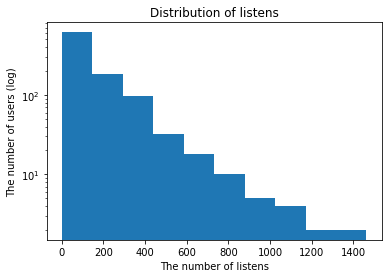

In [ ]:
plt.hist(counts, log = True)
plt.title('Distribution of listens')
plt.xlabel('The number of listens')
plt.ylabel('The number of users (log)')
# plt.savefig('task9.png')
plt.show()

Many users have very few listens. Let's set 20 listens as a threshold. Let's define users with < 20 listens as cold-start users. What is the MRR for ONLY these users, versus "normal" with 20 or more listens?

In [ ]:
def filter(uids: np.ndarray) -> float:
  '''
  Filter the test dataset to compute MRR for wanted users.

  Parameters
  ----------
  uids : the uids of wanted users

  Returns
  -------
  mrr : the MRR for wanted users
  '''

  id_filter = np.where(np.isin(itest.user_ids, uids))  # Generate an ID filter for selecting wanted data.
  itest_new = Interactions(user_ids = itest.user_ids[id_filter], item_ids = itest.item_ids[id_filter], num_users = len(LFMuid_map), num_items = len(LFMiid_map))  # Filter itest.
  return mrr_score(imodel, itest_new).mean()

In [ ]:
# Get the uids for cold-start/normal users in the training dataset.
cold_uids = unique_users[np.where(counts < 20)]
normal_uids = unique_users[np.where(counts >= 20)]

# Filter the test dataset to compute MRR for cold-start/normal users.
itest_cold_mrr = filter(cold_uids)
itest_normal_mrr = filter(normal_uids)

print('For %d cold-start users, MRR: %s' % (cold_uids.size, round(itest_cold_mrr, 4)))
print('For %d normal users, MRR: %s' % (normal_uids.size, round(itest_normal_mrr, 4)))

For 161 cold-start users, MRR: 0.0004
For 811 normal users, MRR: 0.0368


## Task 10. BPR

Finally, let's compare the *pointwise* implicit factorisation model with *BPR*. BPR is a very key recommendation model in the literature, which is widely used today as a baseline in many research papers.

Train an `ImplicitFactorizationModel` on the training dataset of the LastFM dataset (i.e. `itrain`) using identical settings as before, except adding `loss = 'bpr'`. Record the time taken to train, and then evaluate its effectiveness in terms of MRR. Do NOT use the `train = itrain` argument to `mrr_score()`. 

In [ ]:
# Build and train an implicit factorisation model with BPR.
imodel_bpr = ImplicitFactorizationModel(n_iter = 5, loss = 'bpr', random_state = np.random.RandomState(SEED))
current = time.time()
imodel_bpr.fit(itrain, verbose = True)
end = time.time()
print('Training took %d seconds' % (end - current))

Epoch 0: loss 0.4740972354888916
Epoch 1: loss 0.14683696522712708
Epoch 2: loss 0.024808155296742917
Epoch 3: loss 0.014375447143614292
Epoch 4: loss 0.01111387666836381
Training took 172 seconds


In [ ]:
round(mrr_score(imodel_bpr, itest).mean(), 4)

0.0581

# End of Exercise

As part of your submission, you should complete the Exercise 2 quiz on Moodle.
You will need to upload your notebook, complete with the **results** of executing the code (including figures and plots).